In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from google.colab import files
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow
from numpy.random import seed
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***Augmentation Data***

---

[Data](https://drive.google.com/drive/folders/17YlP9Roz3_2GM3NM4tecc3URM4JjtbWF?usp=sharing)

In [ ]:
#For augmentation
'''for dir in os.listdir('/content/drive/MyDrive/Train'):
  count=0
  football_index=401
  swimming_index=241
  rowing_index=203
  tennis_index=186
  basketball_index=197
  for sub_folder in os.listdir(os.path.join('/content/drive/MyDrive/Train',dir)):

    if(dir=='Yoga'):
      continue
      
    elif dir =='Football':
      folder_path=os.path.join('/content/drive/MyDrive/Train',dir)
      
      img=cv2.imread(os.path.join(folder_path,sub_folder))
      horizontal=cv2.flip(img,1)
      path=os.path.join('/content/drive/MyDrive/agumentation/Football','Football_'+str(football_index)+'.jpeg')
      cv2.imwrite(path,horizontal)
      football_index=football_index+1
      if(count==50):
        break
      count=count+1

    elif dir =='Swimming':
      folder_path=os.path.join('/content/drive/MyDrive/Train',dir)
      
      img=cv2.imread(os.path.join(folder_path,sub_folder))
      horizontal=cv2.flip(img,1)
      path=os.path.join('/content/drive/MyDrive/agumentation/Swimming','Swimming_'+str(swimming_index)+'.jpeg')
      cv2.imwrite(path,horizontal)
      swimming_index=swimming_index+1
      if(count==210):
        break
      count=count+1

    elif dir =='Rowing':
      folder_path=os.path.join('/content/drive/MyDrive/Train',dir)
      img=cv2.imread(os.path.join(folder_path,sub_folder))
      horizontal=cv2.flip(img,1)
      path=os.path.join('/content/drive/MyDrive/agumentation/Rowing','Rowing_'+str(rowing_index)+'.jpeg')
      cv2.imwrite(path,horizontal)
      rowing_index=rowing_index+1
      
      if(count<48):
        verticle=cv2.flip(img,0)
        path=os.path.join('/content/drive/MyDrive/agumentation/Rowing','Rowing_'+str(rowing_index)+'.jpeg')
        cv2.imwrite(path,verticle)
        rowing_index=rowing_index+1
            
      count=count+1
    
    elif dir =='Tennis':
      folder_path=os.path.join('/content/drive/MyDrive/Train',dir)
      img=cv2.imread(os.path.join(folder_path,sub_folder))
      horizontal=cv2.flip(img,1)
      path=os.path.join('/content/drive/MyDrive/agumentation/Tennis','Tennis_'+str(tennis_index)+'.jpeg')
      cv2.imwrite(path,horizontal)
      tennis_index=tennis_index+1
      
      if(count<80):
        verticle=cv2.flip(img,0)
        path=os.path.join('/content/drive/MyDrive/agumentation/Tennis','Tennis_'+str(tennis_index)+'.jpeg')
        cv2.imwrite(path,verticle)
        tennis_index=tennis_index+1
            
      count=count+1
    
    elif dir =='Basketball':
      folder_path=os.path.join('/content/drive/MyDrive/Train',dir)
      img=cv2.imread(os.path.join(folder_path,sub_folder))
      horizontal=cv2.flip(img,1)
      path=os.path.join('/content/drive/MyDrive/agumentation/Basketball','Basketball_'+str(basketball_index)+'.jpeg')
      cv2.imwrite(path,horizontal)
      basketball_index=basketball_index+1
      
      if(count<58):
        verticle=cv2.flip(img,0)
        path=os.path.join('/content/drive/MyDrive/agumentation/Basketball','Basketball_'+str(basketball_index)+'.jpeg')
        cv2.imwrite(path,verticle)
        basketball_index=basketball_index+1
            
      count=count+1
      '''

#agumentation Model

##load Data after agumentation

In [ ]:
data=tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/After_Agumentation',labels='inferred',class_names=['Basketball','Football','Rowing','Swimming','Tennis','Yoga'],label_mode='categorical',seed=42)

Found 2712 files belonging to 6 classes.


In [ ]:
data_iterator=data.as_numpy_iterator()

In [ ]:
batch=data_iterator.next()

In [ ]:
len(data)

85

In [ ]:
batch[0].shape

(32, 256, 256, 3)

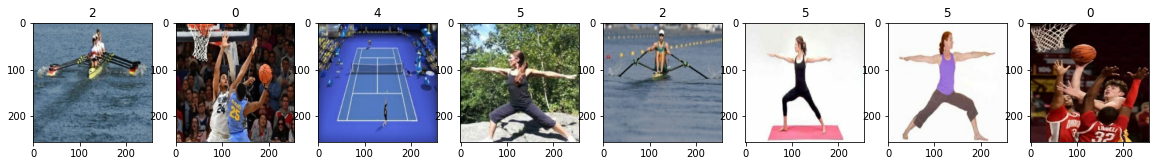

In [ ]:
fig,ax=plt.subplots(ncols=8,figsize=(20,20))
for idx, img in enumerate(batch[0][0:8]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

## preprocessing

###Scaled data

In [ ]:
data=data.map(lambda x,y : (x/255,y))

### Spliting Data

In [ ]:
len(data)

85

In [ ]:
train_size=int(len(data)*0.8)
val_size=int(len(data)*0.2)+1


train=data.take(train_size)
val=data.skip(train_size).take(val_size)


In [ ]:
len(train)

68

In [ ]:
len(val)

17

## Inception model

### Build model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Dropout

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

def inception_module(x, base_channels=16):
  a = Conv2D(base_channels*2, 1, 1, activation='relu')(x)

  b_1 = Conv2D(base_channels*2, 1, 1, activation='relu')(x)
  b_2 = Conv2D(base_channels*4, 3, 1, padding='same', activation='relu')(b_1)

  c_1 = Conv2D(base_channels, 1, 1, activation='relu')(x)
  c_2 = Conv2D(base_channels, 5, 1, padding='same', activation='relu')(c_1)

  d_1 = MaxPooling2D(3, 1, padding='same')(x)
  d_2 = Conv2D(base_channels, 1, 1, activation='relu')(d_1)

  return Concatenate(axis=-1)([a, b_2, c_2, d_2])

inp = Input((256,256, 3))

maps_1 = inception_module(inp)
max_1 = MaxPooling2D()(maps_1)


maps_2 = inception_module(max_1, base_channels=32)
max_2 = MaxPooling2D()(maps_2)


maps_3 = inception_module(max_2, base_channels=16)
max_3 = MaxPooling2D()(maps_3)

maps_4 = inception_module(max_3, base_channels=32)
max_4 = MaxPooling2D()(maps_4)


maps_5 = inception_module(max_4, base_channels=64)
max_5 = MaxPooling2D()(maps_5)

flat=Flatten()(max_5)
output = Dense(45, activation='relu',)(flat)
output = Dense(6, activation='softmax')(output)

model = Model(inputs=inp, outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  128         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_3 (Conv2D)              (None, 256, 256, 16  64          ['input_1[0][0]']                
                                )                                                             

###Train model

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Learning rate is also a hyperparameter
model.compile(loss=CategoricalCrossentropy(), 
              optimizer=Adam(), metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5, monitor='loss')

In [ ]:
hist=model.fit(train,epochs=30,validation_data=val,callbacks=[es],shuffle=False)

Epoch 1/30
68/68 [==============================] - 918s 12s/step - loss: 1.5796 - accuracy: 0.3552 - val_loss: 1.1339 - val_accuracy: 0.5578
Epoch 2/30
68/68 [==============================] - 42s 604ms/step - loss: 1.0232 - accuracy: 0.6167 - val_loss: 0.8200 - val_accuracy: 0.7090
Epoch 3/30
68/68 [==============================] - 41s 598ms/step - loss: 0.8125 - accuracy: 0.7137 - val_loss: 0.7390 - val_accuracy: 0.7201
Epoch 4/30
68/68 [==============================] - 42s 601ms/step - loss: 0.6345 - accuracy: 0.7831 - val_loss: 0.7665 - val_accuracy: 0.7687
Epoch 5/30
68/68 [==============================] - 41s 598ms/step - loss: 0.5491 - accuracy: 0.8157 - val_loss: 0.5303 - val_accuracy: 0.8172
Epoch 6/30
68/68 [==============================] - 41s 598ms/step - loss: 0.4398 - accuracy: 0.8525 - val_loss: 0.6103 - val_accuracy: 0.8004
Epoch 7/30
68/68 [==============================] - 41s 599ms/step - loss: 0.4229 - accuracy: 0.8580 - val_loss: 0.5706 - val_accuracy: 0.8377


### plot performance

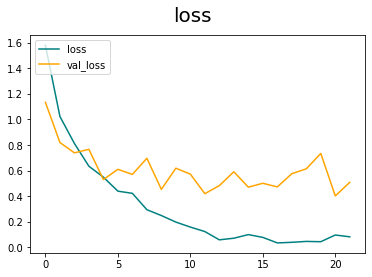

In [ ]:
fig=plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('loss',fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.metrics import Accuracy

In [ ]:
acc = Accuracy()

In [ ]:
for batch in val.as_numpy_iterator(): 
    X, y = batch
    y=np.argmax(y,axis=1)
    yhat = model.predict(X)
    yhat=np.argmax(yhat,axis=1)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 268ms/step


In [ ]:
print(acc.result().numpy())

0.8955224


In [ ]:
real_y=np.array([])
preds=np.array([])
for batch in val.as_numpy_iterator(): 
    X, y = batch
    y=np.argmax(y,axis=1)
    real_y=np.append(real_y,y)
    
    yhat = model.predict(X)
    yhat=np.argmax(yhat,axis=1)
    preds=np.append(preds,yhat)


1/1 [==============================] - 0s 31ms/step


In [ ]:
print(real_y.shape)
print(preds.shape)

(536,)
(536,)


In [ ]:
#fehm error ana m4 3arfh
#get labels and predection for confusion matrix validation
real_labels=np.array([])
for image_batch , label_batch in val:
  arg_lebel=np.argmax(label_batch,axis=1)
  real_labels=np.append(real_labels,arg_lebel)
  
real_labels=real_labels.reshape(-1,1)  
preds=model.predict(val,)
preds=np.argmax(preds,axis=1).reshape(-1,1)


26/26 [==============================] - 10s 156ms/step


0.9011194029850746


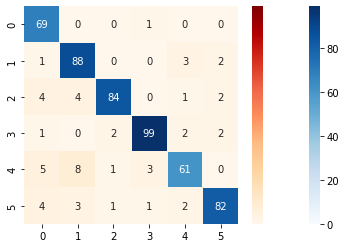

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix,accuracy_score


cf_matrix = confusion_matrix(y_true=real_y, y_pred=preds)

vmin = np.min(cf_matrix)
vmax = np.max(cf_matrix)
off_diag_mask = np.eye(*cf_matrix.shape, dtype=bool)

fig = plt.figure()
sns.heatmap(cf_matrix, annot=True, mask=~off_diag_mask, cmap='Blues', vmin=vmin, vmax=vmax)
sns.heatmap(cf_matrix, annot=True, mask=off_diag_mask, cmap='OrRd', vmin=vmin, vmax=vmax, cbar_kws=dict(ticks=[]))

acc=accuracy_score(real_y,preds)
print(acc)

In [ ]:
np.sum(real_y==preds)/536

0.9011194029850746

### try agumented ver2

In [ ]:
data=tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/agumentation_ver2',labels='inferred',class_names=['Basketball','Football','Rowing','Swimming','Tennis','Yoga'],label_mode='categorical',batch_size=64,seed=42)

Found 5424 files belonging to 6 classes.


In [ ]:
data=data.map(lambda x,y : (x/255,y))
print(len(data))
train_size=int(len(data)*0.8)
val_size=int(len(data)*0.2)+1


train=data.take(train_size)
val=data.skip(train_size).take(val_size)
print(len(train))
print(len(val))

85
68
17


In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

def inception_module(x, base_channels=16):
  a = Conv2D(base_channels*2, 1, 1, activation='relu')(x)

  b_1 = Conv2D(base_channels*2, 1, 1, activation='relu')(x)
  b_2 = Conv2D(base_channels*4, 3, 1, padding='same', activation='relu')(b_1)

  c_1 = Conv2D(base_channels, 1, 1, activation='relu')(x)
  c_2 = Conv2D(base_channels, 5, 1, padding='same', activation='relu')(c_1)

  d_1 = MaxPooling2D(3, 1, padding='same')(x)
  d_2 = Conv2D(base_channels, 1, 1, activation='relu')(d_1)

  return Concatenate(axis=-1)([a, b_2, c_2, d_2])

inp = Input((256,256, 3))

maps_1 = inception_module(inp)
max_1 = MaxPooling2D()(maps_1)


maps_2 = inception_module(max_1, base_channels=32)
max_2 = MaxPooling2D()(maps_2)


maps_3 = inception_module(max_2, base_channels=16)
max_3 = MaxPooling2D()(maps_3)

maps_4 = inception_module(max_3, base_channels=32)
max_4 = MaxPooling2D()(maps_4)


maps_5 = inception_module(max_4, base_channels=64)
max_5 = MaxPooling2D()(maps_5)

flat=Flatten()(max_5)
output = Dense(75, activation='relu',)(flat)
output=Dropout(0.3)(output)
output = Dense(6, activation='softmax')(output)

model = Model(inputs=inp, outputs=output)

model.summary()

####Train model

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Learning rate is also a hyperparameter
model.compile(loss=CategoricalCrossentropy(), 
              optimizer=Adam(), metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5, monitor='loss')

In [ ]:
hist=model.fit(train,epochs=30,validation_data=val,callbacks=[es],shuffle=False)

Epoch 1/30
68/68 [==============================] - 495s 6s/step - loss: 1.4954 - accuracy: 0.4049 - val_loss: 1.0736 - val_accuracy: 0.6213
Epoch 2/30
68/68 [==============================] - 85s 1s/step - loss: 1.0008 - accuracy: 0.6448 - val_loss: 0.9393 - val_accuracy: 0.6642
Epoch 3/30
68/68 [==============================] - 85s 1s/step - loss: 0.8026 - accuracy: 0.7190 - val_loss: 0.6551 - val_accuracy: 0.7715
Epoch 4/30
68/68 [==============================] - 85s 1s/step - loss: 0.6847 - accuracy: 0.7580 - val_loss: 0.4968 - val_accuracy: 0.8246
Epoch 5/30
68/68 [==============================] - 87s 1s/step - loss: 0.5881 - accuracy: 0.7900 - val_loss: 0.4493 - val_accuracy: 0.8396
Epoch 6/30
68/68 [==============================] - 84s 1s/step - loss: 0.4654 - accuracy: 0.8341 - val_loss: 0.4029 - val_accuracy: 0.8638
Epoch 7/30
68/68 [==============================] - 85s 1s/step - loss: 0.4103 - accuracy: 0.8555 - val_loss: 0.4649 - val_accuracy: 0.8386
Epoch 8/30
68/68 [=

In [ ]:
real_y=np.array([])
preds=np.array([])
for batch in val.as_numpy_iterator(): 
    X, y = batch
    y=np.argmax(y,axis=1)
    real_y=np.append(real_y,y)
    
    yhat = model.predict(X)
    yhat=np.argmax(yhat,axis=1)
    preds=np.append(preds,yhat)

26/26 [==============================] - 11s 156ms/step


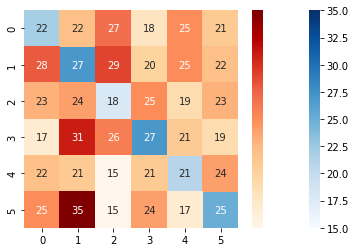

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix,accuracy_score


cf_matrix = confusion_matrix(y_true=real_y, y_pred=preds)

vmin = np.min(cf_matrix)
vmax = np.max(cf_matrix)
off_diag_mask = np.eye(*cf_matrix.shape, dtype=bool)

fig = plt.figure()
sns.heatmap(cf_matrix, annot=True, mask=~off_diag_mask, cmap='Blues', vmin=vmin, vmax=vmax)
sns.heatmap(cf_matrix, annot=True, mask=off_diag_mask, cmap='OrRd', vmin=vmin, vmax=vmax, cbar_kws=dict(ticks=[]))

acc=accuracy_score(real_y,preds)
print(acc)

#### plot performance

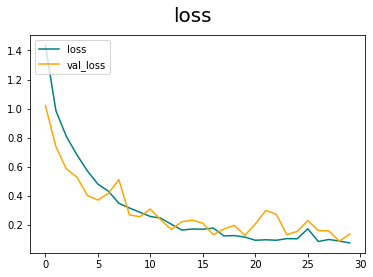

In [ ]:
fig=plt.figure()
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('loss',fontsize=20)
plt.legend(loc='upper left')
plt.show()

#### prediction for kaggel

In [ ]:
import tensorflow.keras.preprocessing.image.ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1/255.)

test_generator = test_datagen('/content/drive/MyDrive/Test',
                              # only read images from `test` directory
                              classes=['Test'],
                              # don't generate labels
                              class_mode=None,
                              # don't shuffle
                              shuffle=False,
                              # use same size as in training
                              target_size=(256, 256))

preds = model.predict_generator(test_generator)